In [92]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
from tifffile import imread
from glob import glob
import math
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from skimage import data, segmentation, feature, future
from functools import partial
import matplotlib.animation as animation

sys.path.append("/home/cstansbu/.local/lib/python3.9/site-packages/")
import skimage
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

import utils as ut
from importlib import reload 
reload(ut)

<module 'utils' from '/home/cstansbu/git_repositories/pip-fucci/notebooks/utils.py'>

In [2]:
# load our data

dirPath = "/nfs/turbo/umms-indikar/shared/projects/wound_healing/data/Incucyte-redgreen/"

df = []

for f in os.listdir(dirPath):
    fullPath = f"{dirPath}{f}"
    chan = f.split("_")[1].split(".")[0][-1]
    time = f.split("s01t")[1].split("c")[0]
    
    im = skimage.io.imread(fullPath, as_gray=True)
    
    row = {
        'file' : f,
        'channel' : int(chan),
        'time' : int(time),
        'image' : im,
    }
    
    df.append(row)
    
    
df = pd.DataFrame(df)
print(f"{df.shape=}")
df = df.sort_values(by=['time', 'channel'], ascending=[True, True])
df = df.reset_index(drop=True)
df.head()

df.shape=(120, 4)


,file,channel,time,image
0,Incucyte-redgreen_s01t001c1.jpg,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Incucyte-redgreen_s01t001c3.jpg,3,1,"[[0.03140313725490196, 0.014027450980392157, 0..."
2,Incucyte-redgreen_s01t002c1.jpg,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Incucyte-redgreen_s01t002c3.jpg,3,2,"[[0.009249803921568628, 0.005610980392156863, ..."
4,Incucyte-redgreen_s01t003c1.jpg,1,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [3]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.


2023-04-21 08:25:49.587697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-04-21 08:25:49.604349: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-21 08:25:49.604366: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gl3114.arc-ts.umich.edu): /proc/driver/nvidia/version does not exist
2023-04-21 08:25:49.605194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [5]:
?model.predict_instances

Signature:
model.predict_instances(
    img,
    axes=None,
    normalizer=None,
    sparse=True,
    prob_thresh=None,
    nms_thresh=None,
    scale=None,
    n_tiles=None,
    show_tile_progress=True,
    verbose=False,
    return_labels=True,
    predict_kwargs=None,
    nms_kwargs=None,
    overlap_label=None,
    return_predict=False,
)
Docstring:
Predict instance segmentation from input image.

Parameters
----------
img : :class:`numpy.ndarray`
    Input image
axes : str or None
    Axes of the input ``img``.
    ``None`` denotes that axes of img are the same as denoted in the config.
normalizer : :class:`csbdeep.data.Normalizer` or None
    (Optional) normalization of input image before prediction.
    Note that the default (``None``) assumes ``img`` to be already normalized.
sparse: bool
    If true, aggregate probabilities/distances sparsely during tiled
    prediction to save memory (recommended).
prob_thresh : float or None
    Consider only object candidates from pixels wi

In [4]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [104]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

p = 0.35 # default for 2D_versatile_fluo is 0.479071
areaThresh = 20
eccentricityThresh = .8

res = []
segments = {}
cdf = []

for t in df['time'].unique():
    
    tdf = df[df['time'] == t]
    
    c1 = tdf[tdf['channel'] == 1]['image'].values[0]
    c3 = tdf[tdf['channel'] == 3]['image'].values[0]
    
    c1 = ut.cleanImage(c1, gaussian=1.0, median=2, radius=20)
    c3 = ut.cleanImage(c3, gaussian=1.0, median=2, radius=20)
    
    c1labels, _ = model.predict_instances(normalize(c1), prob_thresh=p)
    c3labels, _ = model.predict_instances(normalize(c3), prob_thresh=p)

    joined, m1, m2 = ut.join_segmentations(c1labels, c3labels, return_mapping=True)
    
    phase = ut.phase_count(m1, m2)
    
    props = skimage.measure.regionprops(joined)
    pdf = ut.getRegionPropsTable(props)
    pdf['phase'] = phase['phase']
    pdf['time'] = t
    
    cdf.append(pdf)
    
    # simple filtering
    pdf = pdf[pdf['area_convex'] > areaThresh]
    pdf = pdf[pdf['eccentricity'] < eccentricityThresh]
    
    counts = pdf['phase'].value_counts()
    
    nRow = dict(counts)
    nRow['time'] = t
    res.append(nRow)
    
    img = np.dstack((c1,c3))
    
    segments[t] = [img, c1labels, c3labels, joined]

cdf = pd.concat(cdf)
print(f"{cdf.shape=}")
print(cdf.head())
print()
    
res = pd.DataFrame(res)
res['total'] = res[['m1', 'm2', 'm1m2']].sum(axis=1)
print(f"{res.shape=}")
print(res.head())



Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
1/1 [==============================] - 0s 64ms/step
cdf.shape=(11150, 15)
   area  area_convex  area_filled  axis_major_length  axis_minor_length  \
0  75.0         78.0         75.0          10.059214           9.511020   
1  63.0         67.0         63.0           9.345753           8.574826   
2  72.0         77.0         72.0          10.109228           9.152739   
3  49.0         52.0         49.0           8.583557           7.316844   
4  50.0         53.0         50.0           8.250359           7.794689   

   centroid_y  centroid_x  eccentricity  label  orientation  perimeter  \
0  351.400000  167.426667      0.325613      1     0.647924  29.556349   
1  126.000000  535.571429      0.397712      2     0.441055  27.313708   
2   42.486111  474.958333      0.424592      3    -0

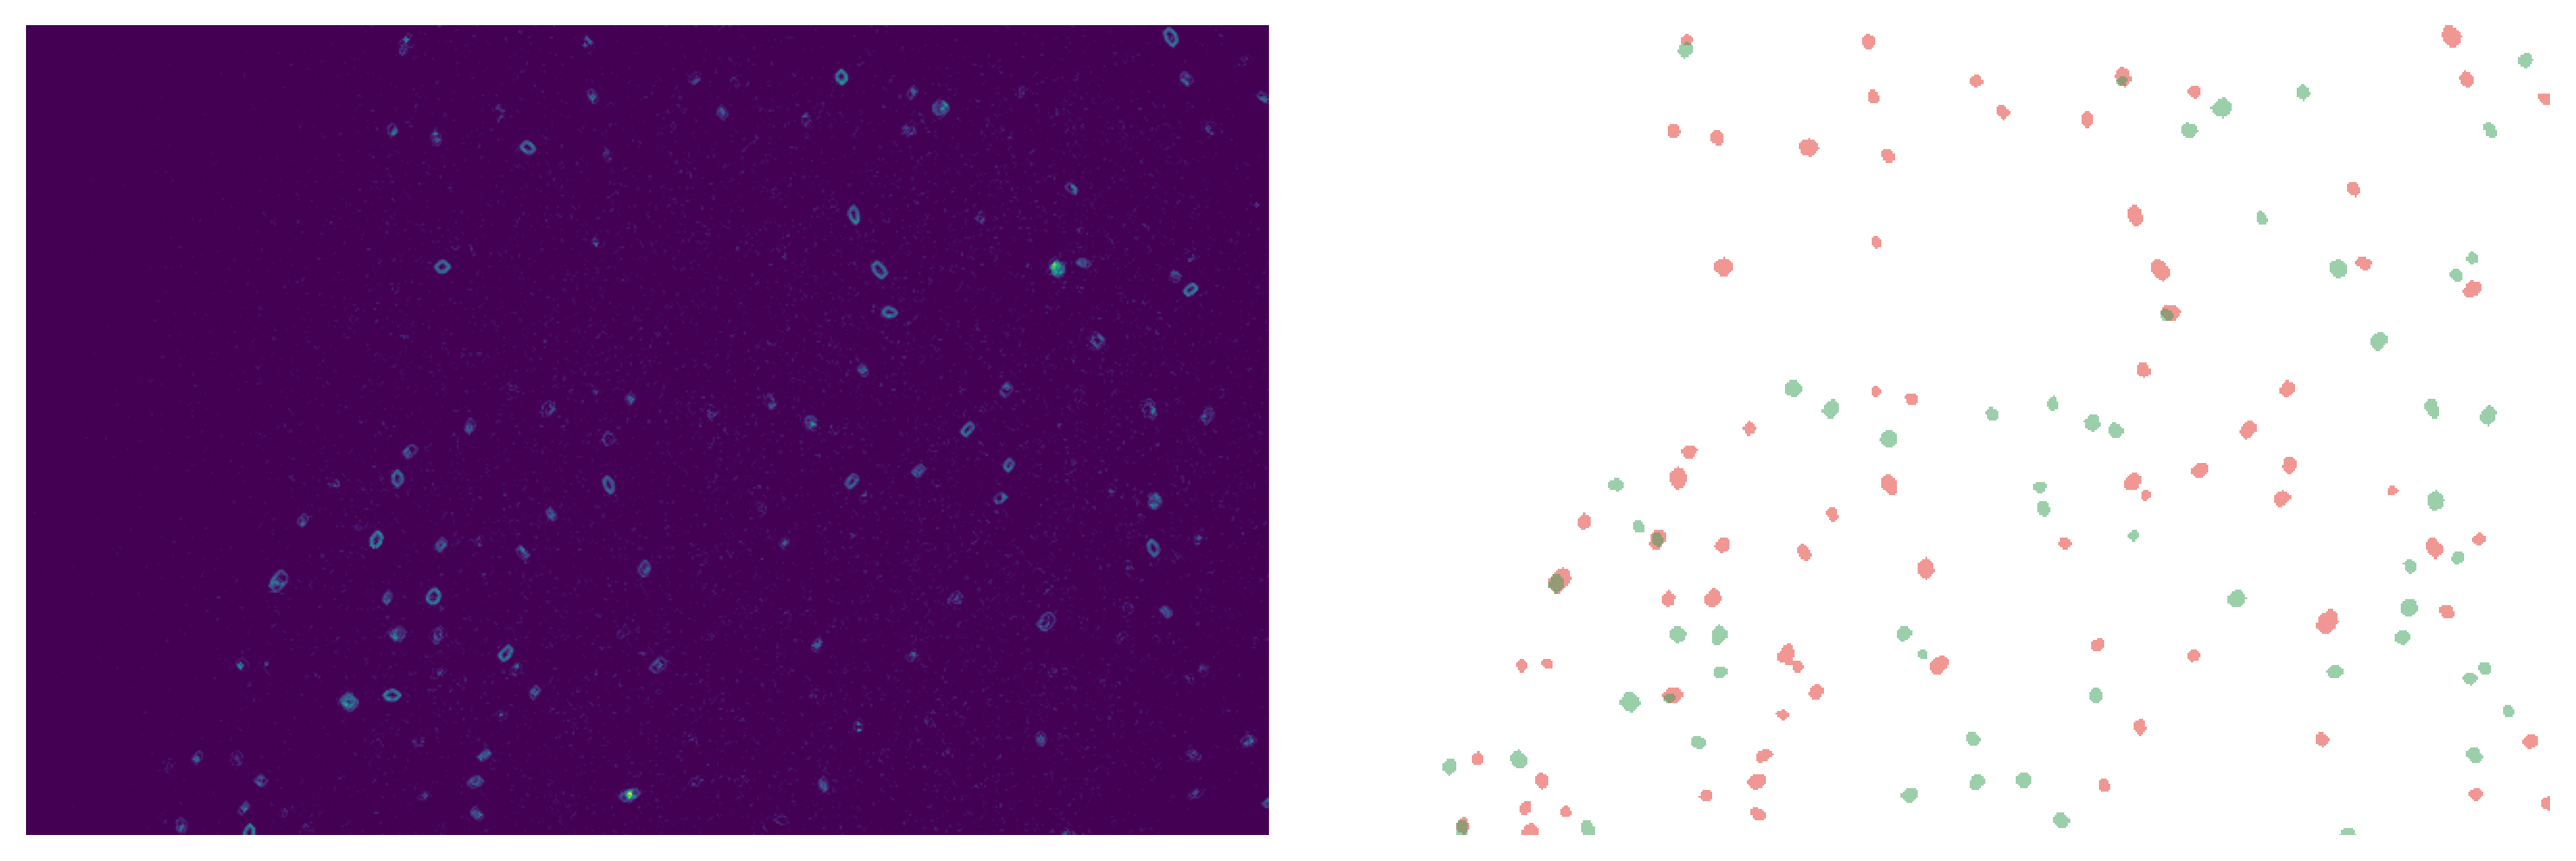

In [105]:
im, c1, c3, joined = segments[1]

c1 = skimage.segmentation.expand_labels(c1, distance=1)
c3 = skimage.segmentation.expand_labels(c3, distance=1)

c1 = np.where(c1 > 0, 1, np.nan)
c3 = np.where(c3 > 0, 1, np.nan)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 5

fig, axs = plt.subplots(1, 2)
axs[0].imshow(im.mean(axis=2))
axs[0].axis(False)

axs[1].imshow(c1, cmap='Reds', vmin=0, vmax=1.5, alpha=0.5)
axs[1].imshow(c3, cmap='Greens', vmin=0, vmax=1.5, alpha=0.5)
axs[1].axis(False)
plt.tight_layout()

MovieWriter ffmpeg unavailable; using Pillow instead.


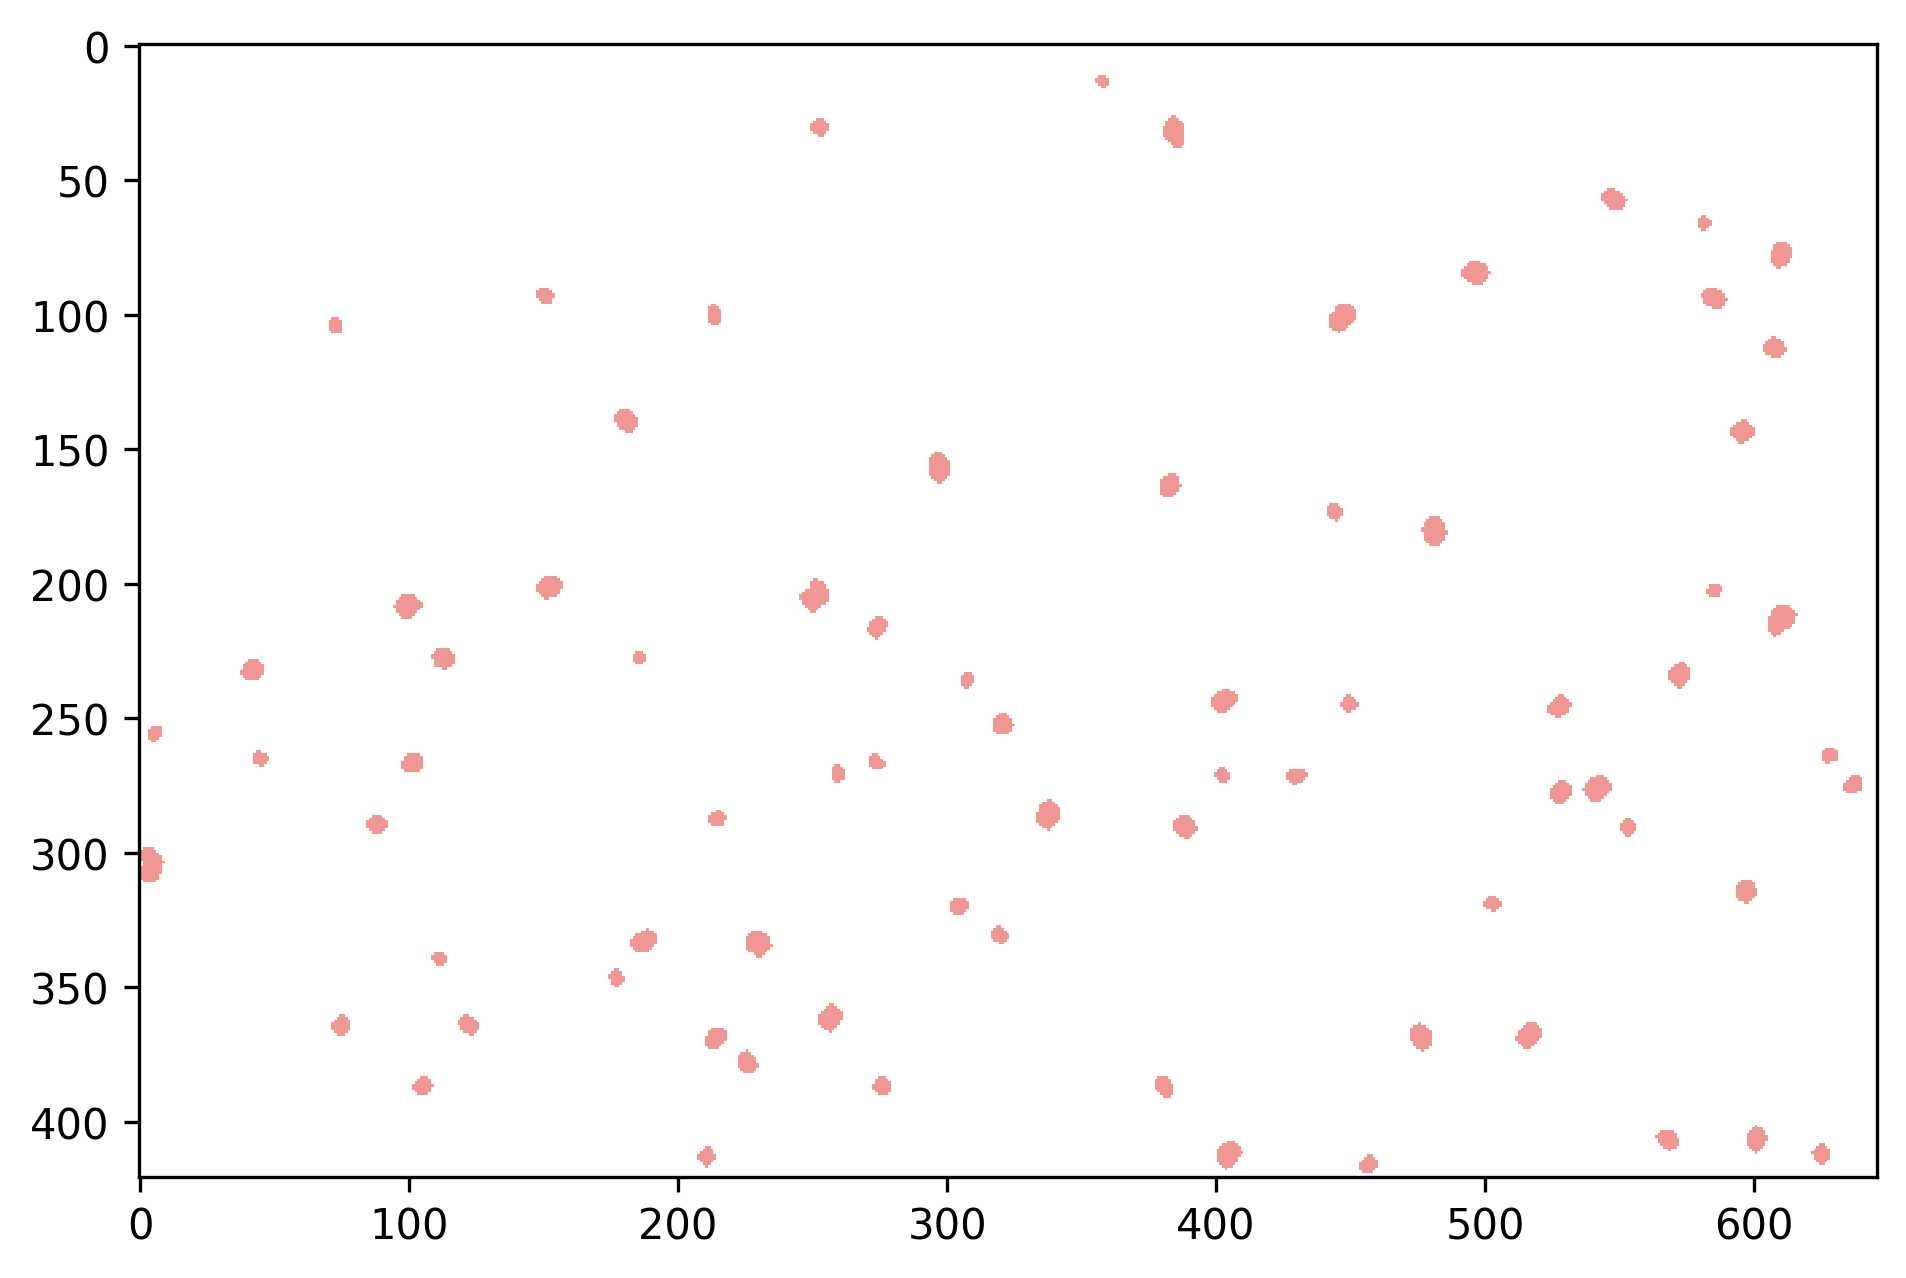

In [106]:
# make the movie

ims = []


fig = plt.figure()

for t, (im, c1, c3, joined) in segments.items():
    c1 = skimage.segmentation.expand_labels(c1, distance=1)
    c3 = skimage.segmentation.expand_labels(c3, distance=1)
    
    # binary segmentation
    c1 = np.where(c1 > 0, 1, np.nan)
    c3 = np.where(c3 > 0, 1, np.nan)
    
    im = plt.imshow(c1, cmap='Reds', vmin=0, vmax=1.5, alpha=0.5, animated=True)
    # plt.imshow(c3, cmap='Greens', vmin=0, vmax=1.5, alpha=0.5)
    
    ims.append([im])
    
    # meanIm = im.mean(axis=2)im = 

ani = animation.ArtistAnimation(fig, 
                                ims, 
                                interval=50, 
                                blit=True,
                                repeat_delay=50)

ani.save('dynamic_images.gif')

plt.show()

Text(0.5, 0, 'Time')

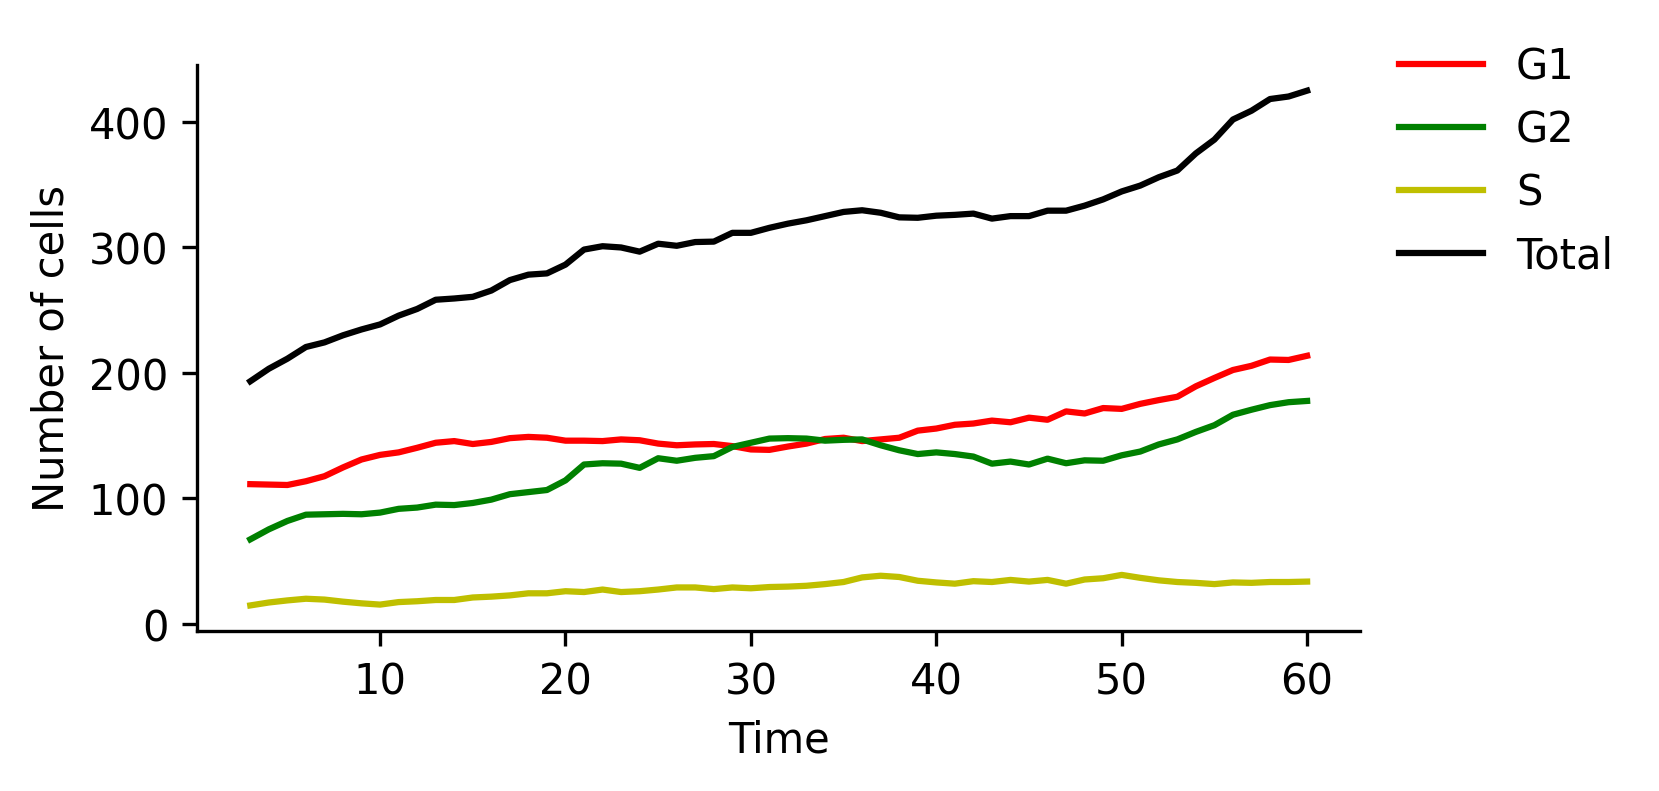

In [91]:
pdf = res.copy()
smooth = 3

cols = ['m1', 'm2', 'm1m2', 'total']

for c in cols:
    pdf[c] = pdf[c].rolling(smooth).mean()

pdf = pd.melt(pdf, id_vars='time', value_vars=cols)

varMap = {
    'm1' : 'G1',
    'm2' : 'G2',
    'm1m2' : 'S',
    'total' : 'Total',
}


pdf['phase'] = pdf['variable'].map(varMap)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5, 2.5

sns.lineplot(data=pdf, 
             x='time',
             y='value',
             hue='phase',
             palette=['r', 'g', 'y', 'k'])

sns.despine()
sns.move_legend(plt.gca(), 
                title="",
                loc='upper right',
                bbox_to_anchor=(1.25,1.1),
                frameon=False)

plt.ylabel("Number of cells")
plt.xlabel("Time")

In [ ]:

def untanlge(row):
    if row['m1'] > 0 and row['m2'] > 0:
        return 'm1m2'
    elif row['m1'] > 0 and row['m2'] == 0:
        return 'm1'
    elif row['m1'] == 0 and row['m2'] > 0:
        return 'm2'
    else:
        return 'err'


def phase_count(m1, m2):
    joined = pd.DataFrame(m1.in_values.ravel(), columns=['joinedLabel'])
    joined['m1'] = joined['joinedLabel'].map(m1)
    joined['m2'] = joined['joinedLabel'].map(m2)
    joined['phase'] = joined.apply(lambda x: untanlge(x), axis=1)
    return joined
    
    
joined = pahse_count(j2c1, j2c3)
joined['phase'].value_counts()


In [ ]:
joined['m2'].nunique()

In [ ]:
j2c1[176]

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 6, 4

segmentChannel = 1

# prints a list of available models
# StarDist2D.from_pretrained()

model = StarDist2D.from_pretrained('2D_versatile_fluo')

for t in [1]:
    fig, axs = plt.subplots(1, 2)
    
    tdf = df[df['time'] == t]
    
    img = tdf[tdf['channel'] == segmentChannel]['image'].values[0]
    labels, _ = model.predict_instances(normalize(img))
    print(f"{img.shape=} {labels.shape=}")
    
    """Raw image """
    axs[0].imshow(img, cmap='gray')
    axs[0].axis(False)
    
    axs[1].imshow(labels, cmap='viridis')
    axs[1].axis(False)
    
    props = skimage.measure.regionprops(labels)
    pdf = getRegionPropsTable(props)
    pdf['time'] = t
    
    ## add other channel information
    c2Img = tdf[tdf['channel'] != segmentChannel]['image'].values[0]
    
    c2Data = []
    
    # for cell in props:
        
    
    
    
    
    
#     for label in pdf['label']:
#         mask = (labels == label)
#         mean = channelImg[mask].mean()
#         means.append(mean)
        
#     pdf['c2mean'] = means
        
        # break
        
    # print(mask)
    
    
    print(pdf.head())
    
    
plt.tight_layout()

In [ ]:
for prop in props:
    print(dir(prop))
    break

In [ ]:
prop.bbox

In [ ]:
fig, axs = plt.subplots(1, 3)

test = c2Img[prop.coords[:, 0], prop.coords[:, 1]]
test.shape

# axs[0].imshow(img, cmap='gray')
# axs[1].imshow(c2Img, cmap='gray')
# axs[2].imshow(test)


In [ ]:
break

In [ ]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/wound_healing/data/Incucyte-redgreen/"

df = []

for f in os.listdir(dirPath):
    fullPath = f"{dirPath}{f}"
    chan = f.split("_")[1].split(".")[0][-1]
    time = f.split("s01t")[1].split("c")[0]
    
    im = skimage.io.imread(fullPath, as_gray=True)
    
    row = {
        'file' : f,
        'channel' : int(chan),
        'time' : int(time),
        'image' : im,
    }
    
    df.append(row)
    
    
df = pd.DataFrame(df)
print(f"{df.shape=}")
df = df.sort_values(by=['time', 'channel'], ascending=[True, True])
df = df.reset_index(drop=True)
df.head()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 6, 4


for t in df['time'].sample(2):
    fig, axs = plt.subplots(1, 2)
    axs = axs.ravel()
    
    tdf = df[df['time'] == t]
    red, green = tdf['image'].values
    print(f"{red.shape=} {green.shape=}")
    
    axs[0].imshow(red, cmap='Reds')
    axs[0].axis(False)
    axs[0].set_title(f"{t=}")
    
    axs[1].imshow(green, cmap='Blues')
    axs[1].axis(False)
    axs[1].set_title(f"{t=}")
    
    plt.show()
    # break
    
plt.tight_layout()

In [ ]:
# train a model

nclasses = 3

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 6, 4

def segment(image, 
            nclasses, 
            sigma=None,
            radius=None, 
            gaussian=None,
            median=None, 
            expand=None):
    """A segmentation proc """
    
    if not median is None:
        footprint = np.ones((median, median))
        image = skimage.filters.median(image, footprint=footprint)
        
    if not gaussian is None:
        image = skimage.filters.gaussian(image, gaussian, truncate=.01)
    
    if not radius is None:
        background = skimage.restoration.rolling_ball(image, radius=radius)
        image = image - background
    
    thresholds = skimage.filters.threshold_multiotsu(image, classes=nclasses)
    image = np.digitize(image, bins=thresholds)
    
    if not expand is None:
        image = skimage.segmentation.expand_labels(image, distance=expand)
    
    return image


def getModel(image):
    training_labels = image+1 # shift trainning labels
    features_func = partial(feature.multiscale_basic_features,
                            intensity=True, 
                            edges=False, 
                            texture=True,
                            sigma_min=0.01,
                            sigma_max=15)

    # get features
    features = features_func(image)

    clf = RandomForestClassifier(n_estimators=50, 
                                 max_depth=10, 
                                 max_samples=0.1)

    clf = future.fit_segmenter(training_labels, features, clf)
    return clf
    
    
    
for t in [45]:
    fig, axs = plt.subplots(2, 2)
    
    tdf = df[df['time'] == t]
    red, green = tdf['image'].values
    
    print(f"{red.shape=} {green.shape=}")
    
    
    """Raw image """
    axs[0, 0].imshow(red, cmap='gray')
    axs[0, 0].axis(False)
    axs[0, 1].imshow(green, cmap='gray')
    axs[0, 1].axis(False)
    
    """ processed images """
    
    rSeg = segment(red, nclasses, gaussian=0.2)
    gSeg = segment(green, nclasses, median=3, 
                   gaussian=0.5, radius=10, expand=1)
    
    axs[1, 0].imshow(rSeg, cmap='viridis')
    axs[1, 0].axis(False)
    axs[1, 1].imshow(gSeg, cmap='viridis')
    axs[1, 1].axis(False)
    
    plt.show()
    
    """Train the models """
    
    redModel = getModel(rSeg)
    greenModel = getModel(gSeg)
    
    print('done')

    
plt.tight_layout()

In [ ]:
# run predictions on all
for idx, row in df.iterrows():
    print(idx)
    
    break
    

In [ ]:
# training_labels = gSeg+1
# features_func = partial(feature.multiscale_basic_features,
#                         intensity=True, 
#                         edges=False, 
#                         texture=True,
#                         sigma_min=0.01,
#                         sigma_max=15)

# features = features_func(green)

# clf = RandomForestClassifier(n_estimators=50, 
#                              n_jobs=-1,
#                              max_depth=10, 
#                              max_samples=0.1)

# clf = future.fit_segmenter(training_labels, features, clf)

# result = future.predict_segmenter(features, clf)


# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
# ax[0].imshow(segmentation.mark_boundaries(green, result, mode='thick'))
# ax[0].contour(training_labels)
# ax[0].set_title('Image, mask and segmentation boundaries')
# ax[0].axis(False)
# ax[1].imshow(result)
# ax[1].set_title('Segmentation')
# ax[1].axis(False)
# fig.tight_layout()

In [ ]:
break

In [ ]:
from csbdeep.utils import Path, download_and_extract_zip_file

download_and_extract_zip_file(
    url       = 'https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = '/scratch/indikar_root/indikar1/cstansbu/wound_healing',
    verbose   = 1,
)

X = sorted(glob('/scratch/indikar_root/indikar1/cstansbu/wound_healing/dsb2018/train/images/*.tif'))
Y = sorted(glob('/scratch/indikar_root/indikar1/cstansbu/wound_healing/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X, Y = X[:10], Y[:10]

X = list(map(imread,X))
Y = list(map(imread,Y))

In [ ]:
len(X)

In [ ]:
i = min(4, len(X)-1)
# i = 0
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [ ]:
from stardist.models import StarDist2D

# # prints a list of available models
# StarDist2D.from_pretrained()

# # creates a pretrained model
# model = StarDist2D.from_pretrained('2D_versatile_fluo')